# _Embeddings with Flair_

In [14]:
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
#from tqdm import tqdm_notebook as tqdm
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [15]:
def home_path():
    return Path.cwd().parent.parent

In [16]:
homepath = home_path()
print(homepath)

/notebooks


In [17]:
%%time
df = pd.read_json(
    homepath/'storage/dailies/daily_20200519.json',
    orient='columns'
)

CPU times: user 8.99 s, sys: 694 ms, total: 9.69 s
Wall time: 9.68 s


## _Retrieve English-only Tweets_

In [18]:
df_eng = df[df['lang'] == 'en'].reset_index(drop=True)

In [19]:
sample = df_eng.sample(n=1000, random_state=1).reset_index(drop=True)

In [20]:
sample.shape

(1000, 5)

## _Embeddings_

In [21]:
import torch
from flair.data import Sentence
from flair.embeddings import FlairEmbeddings, DocumentPoolEmbeddings, BertEmbeddings

# init embedding classes
flair_embedding_forward = FlairEmbeddings('news-forward')
flair_embedding_backward = FlairEmbeddings('news-backward')
bert_embedding = BertEmbeddings('bert-base-uncased')

# combine word embedding models
document_embeddings = DocumentPoolEmbeddings([
    bert_embedding,
    flair_embedding_backward,
    flair_embedding_forward
])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated method __init__. (Use 'TransformerWordEmbeddings' for all transformer-based word embeddings) -- Deprecated since version 0.4.5.
  


In [22]:
# set up empty tensor
X = torch.empty(size=(len(sample.index), 7168)).cuda()

# fill in tensor with embeddings
i = 0
for text in tqdm(sample['full_text']):
    sentence = Sentence(text)
    document_embeddings.embed(sentence)
    embedding = sentence.get_embedding()
    X[i] = embedding
    i += 1

In [23]:
X = X.cpu().detach().numpy()

In [24]:
torch.cuda.empty_cache()

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
X_scale = MinMaxScaler(feature_range=(-1,1)).fit_transform(X)

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.manifold import Isomap, LocallyLinearEmbedding

def pca_plot(X, max_dims=100):
    N = min(X.shape[1],max_dims)
    pca = PCA(n_components=N)
    pca.fit(X)
    _,ax = plt.subplots(figsize=(8,4))
    ax.plot(range(1,N+1),pca.explained_variance_ratio_.cumsum(), c='black', linewidth=2.)
    ax.set_xlim(0,N+1)
    ax.set_yticks(0.1*np.arange(11))
    ax.locator_params(axis='x', nbins=40)
    ax.set_xlabel('principal components')
    ax.set_ylabel('% of variance explained')
    plt.show()

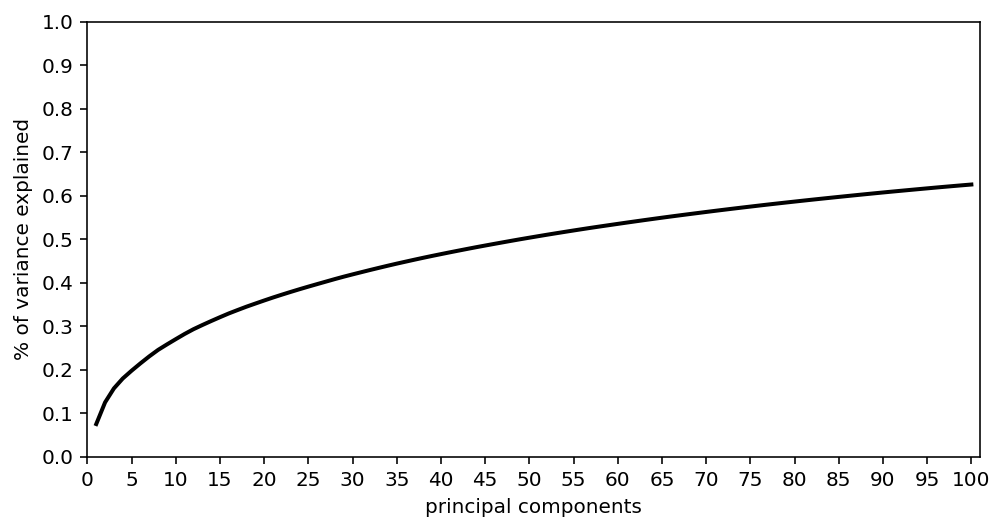

In [28]:
pca_plot(X_scale)

In [29]:
dr = PCA(n_components=2)
dr.fit(X_scale)
X_dr = dr.transform(X_scale)

In [47]:
def plot_reduced_2D(X_dr, dr_type):
    _,ax = plt.subplots(figsize=(10,10))
    ax.scatter(X_dr[:,0],X_dr[:,1], alpha=0.8)
    ax.set_title(dr_type+' with 2 components')
    plt.show()

X_dr shape:  (1000, 2)
X shape:  (1000, 7168)


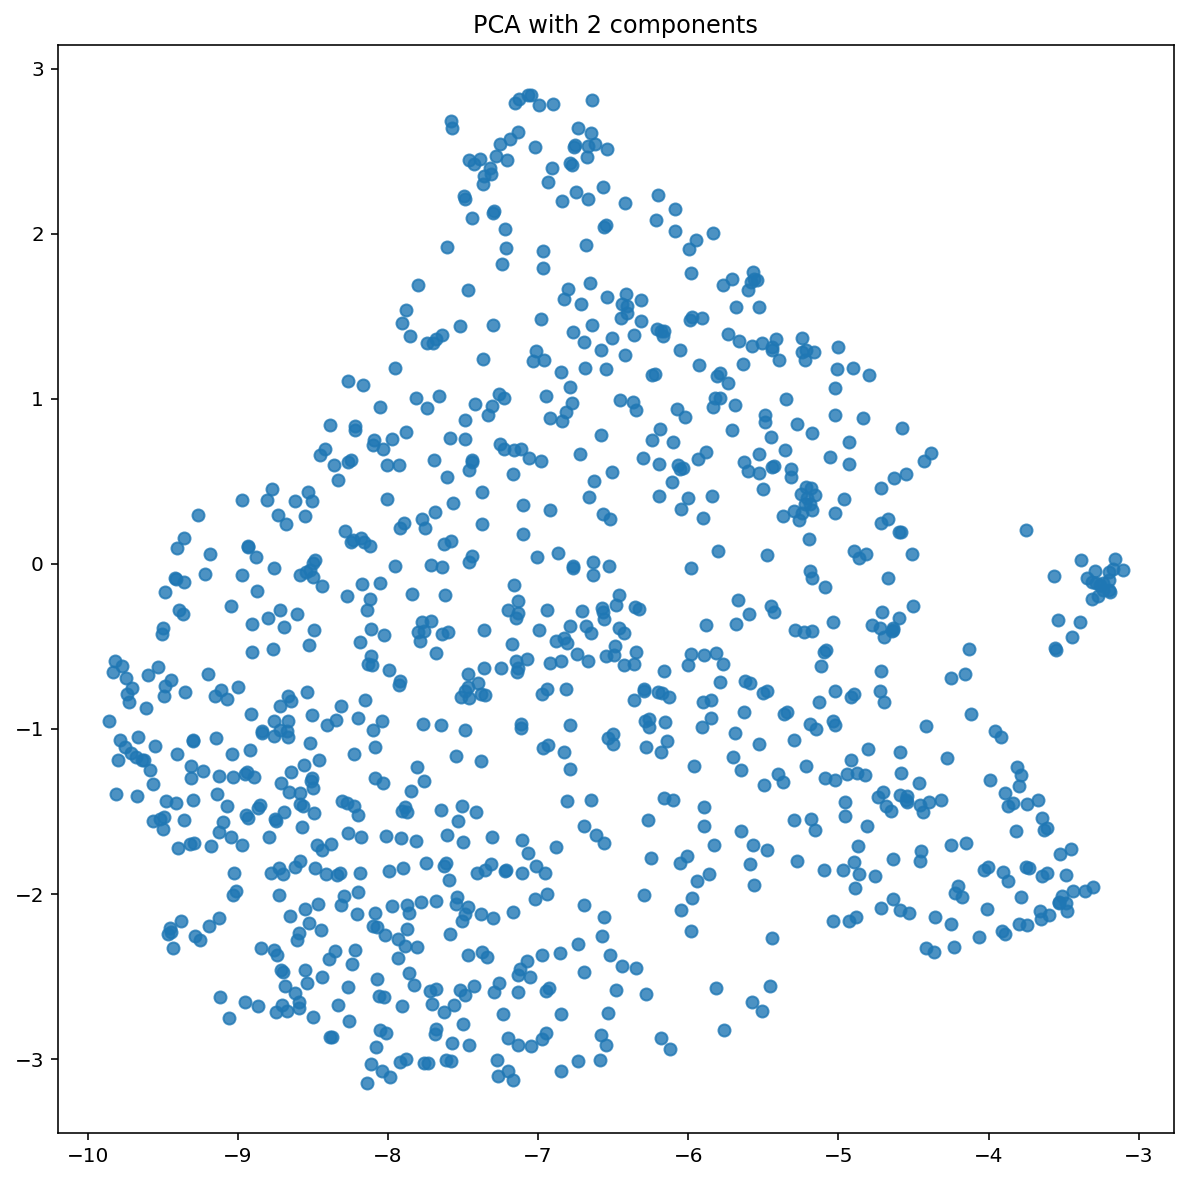

In [48]:
print('X_dr shape: ',X_dr.shape)
print('X shape: ',X.shape)
plot_reduced_2D(X_dr, 'PCA')

In [49]:
import umap
import warnings; warnings.filterwarnings('ignore')

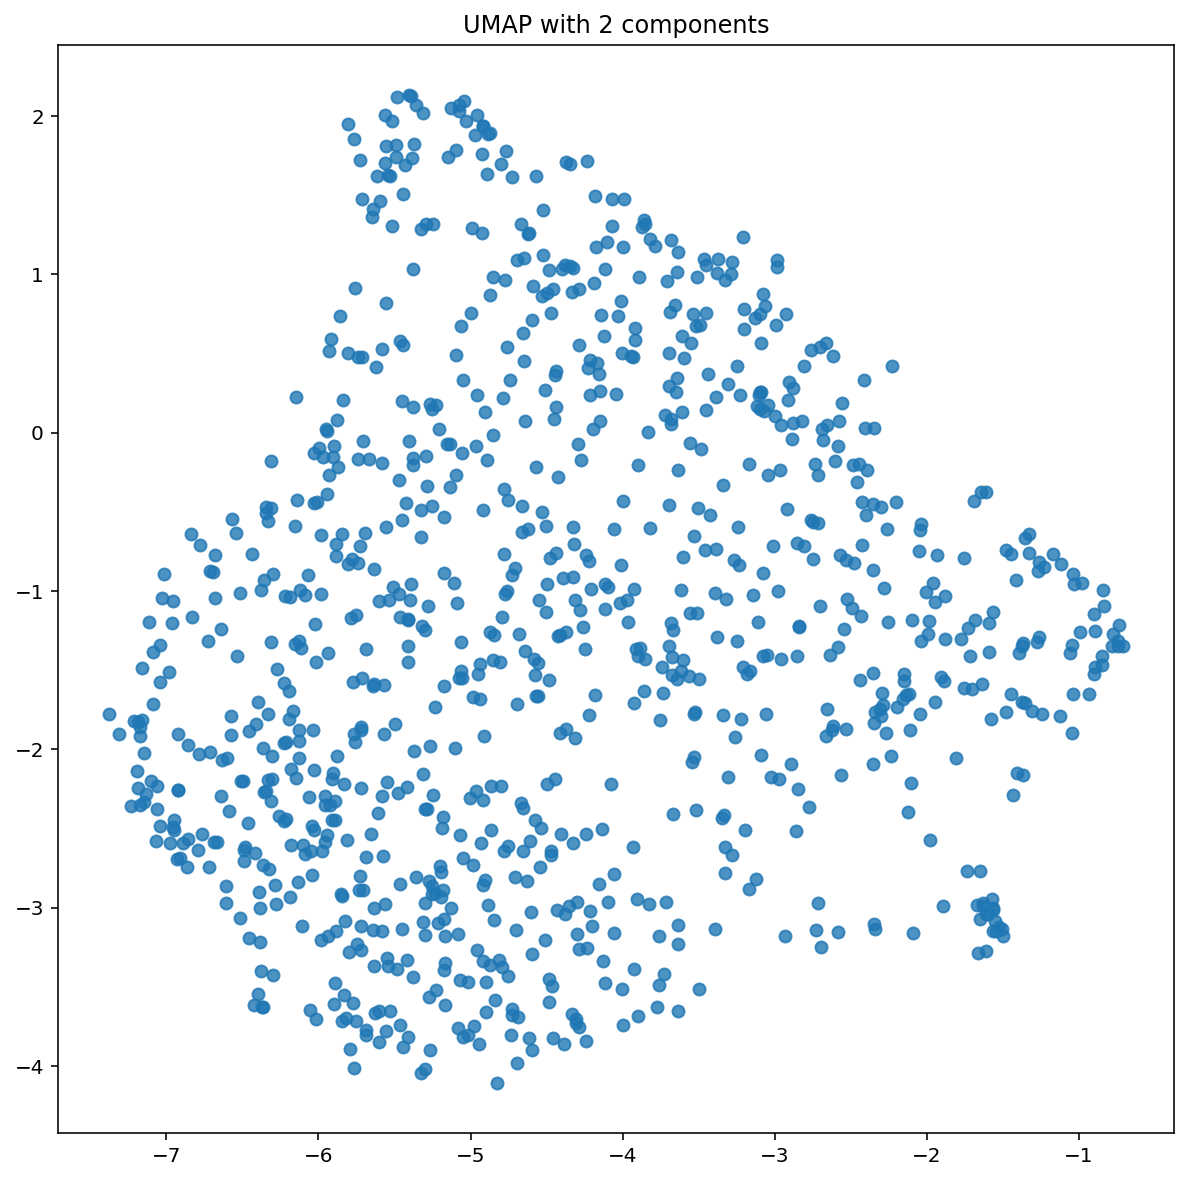

CPU times: user 25.5 s, sys: 1.26 s, total: 26.8 s
Wall time: 14 s


In [50]:
%%time
dr = umap.UMAP(n_components=2, metric='cosine')
dr.fit(X_scale)
X_dr = dr.transform(X_scale)
plot_reduced_2D(X_dr, 'UMAP')

## _Using Raw Counts_

In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [52]:
vectorizer = CountVectorizer(min_df=5, stop_words='english')
word_doc_matrix = vectorizer.fit_transform(sample['full_text'])

In [58]:
%%time
embedding = umap.UMAP(n_components=2, metric='cosine').fit(word_doc_matrix)

CPU times: user 25.6 s, sys: 1.09 s, total: 26.6 s
Wall time: 9.1 s


In [59]:
embedding.embedding_.shape

(1000, 2)

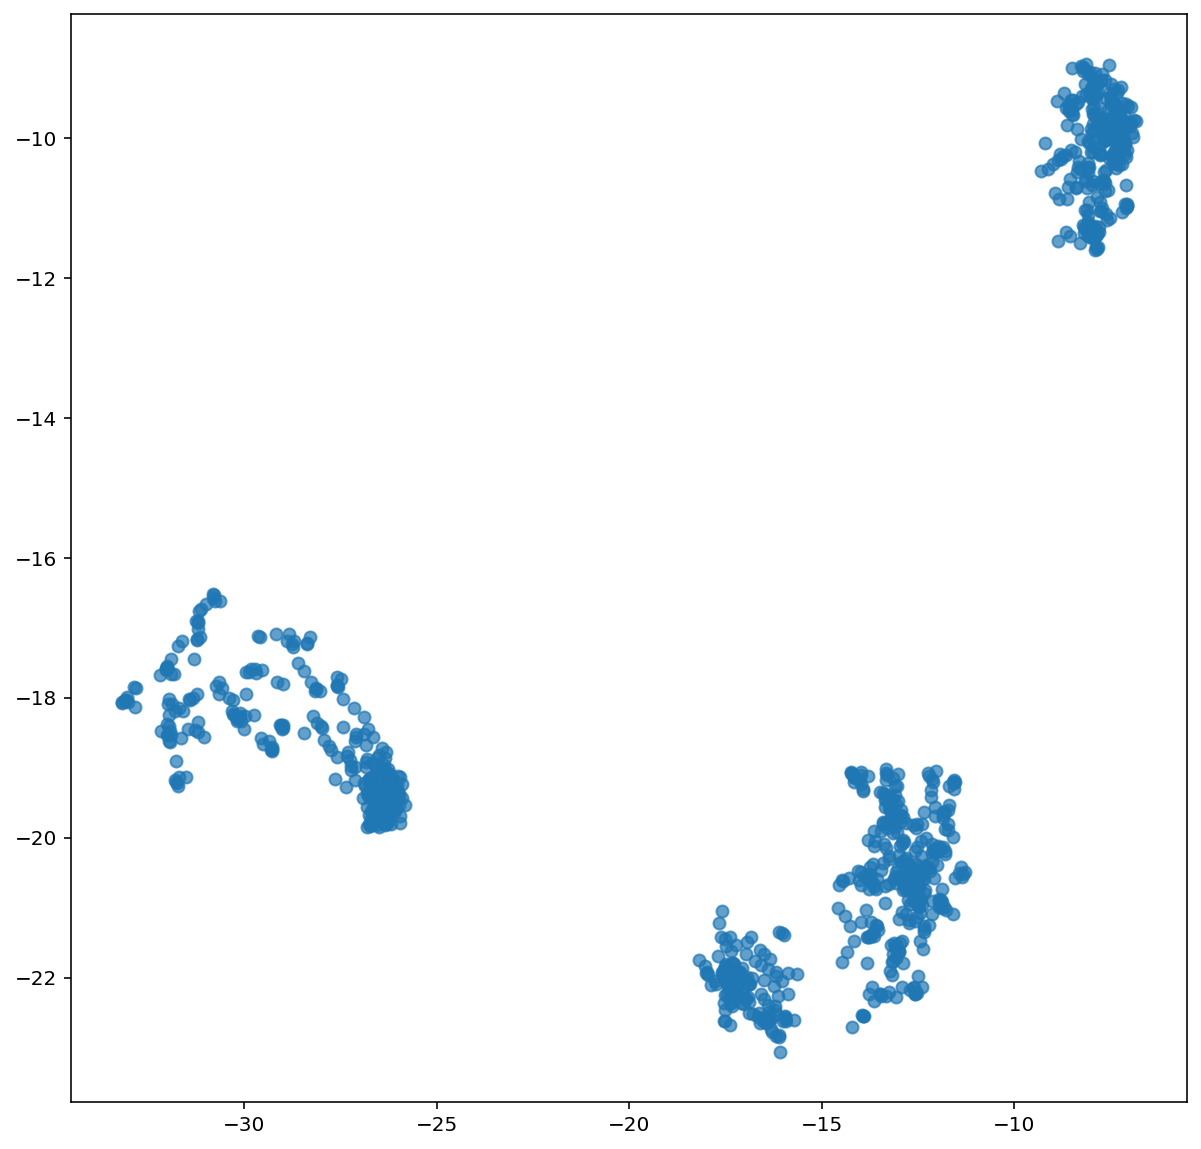

In [61]:
_,ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding.embedding_[:,0], embedding.embedding_[:,1], alpha=0.7)

## _Using TF-IDF_

In [62]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(sample['full_text'])

In [63]:
%%time
embedding = umap.UMAP(n_components=2, metric='cosine').fit(tfidf_word_doc_matrix)

CPU times: user 17.7 s, sys: 872 ms, total: 18.6 s
Wall time: 5.54 s


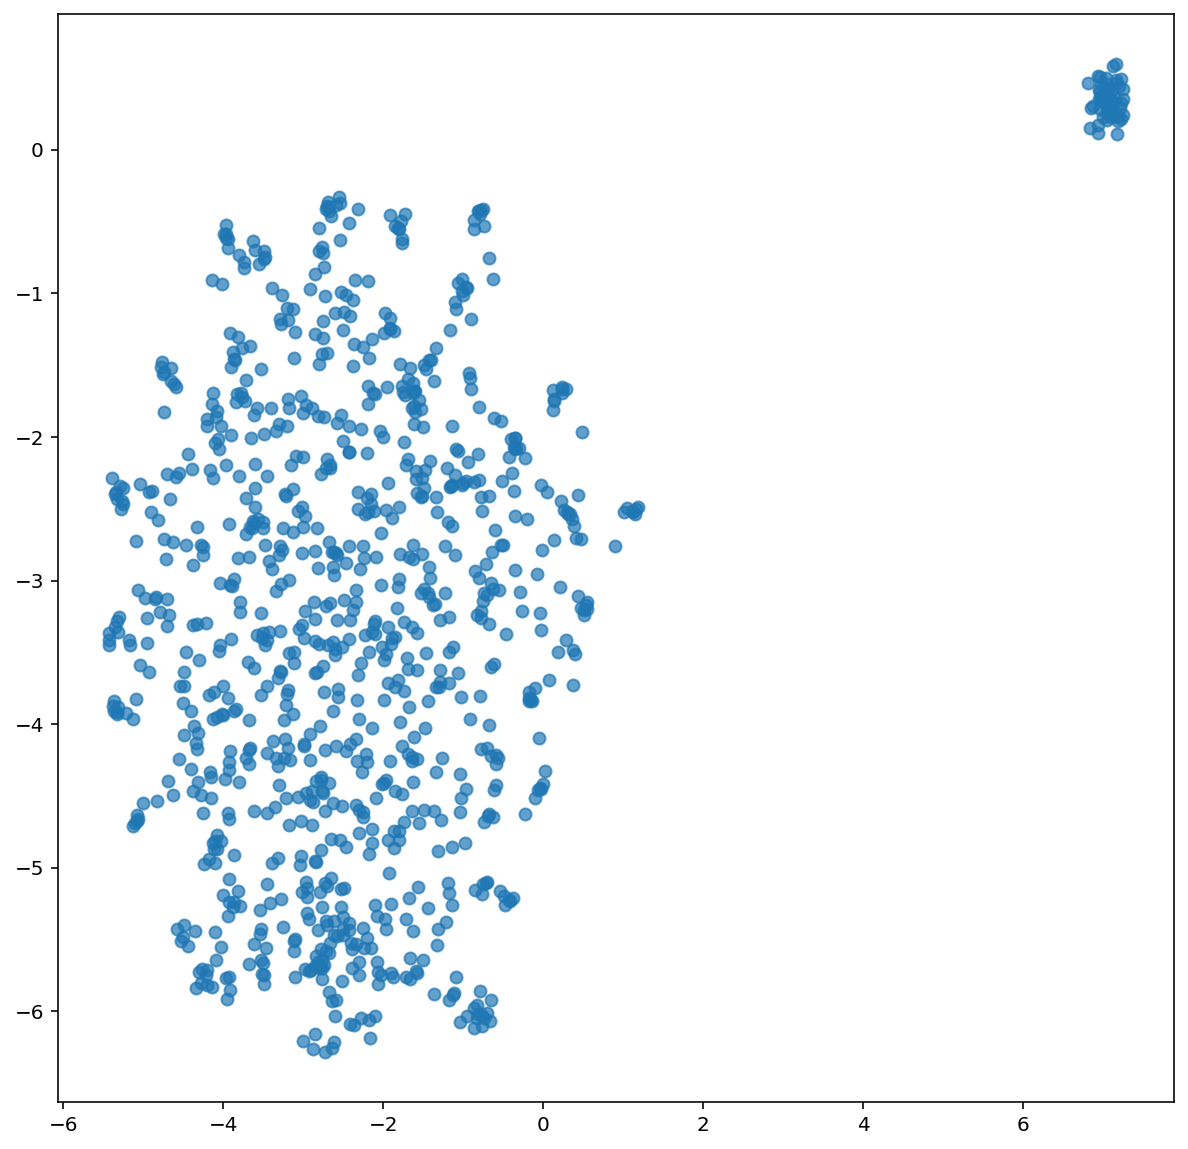

In [64]:
_,ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding.embedding_[:,0], embedding.embedding_[:,1], alpha=0.7)